## This script  make an nc file representing the list of MJO events from 1981-2016

In [1]:
from scipy.io import loadmat
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy as sc
from scipy import stats,signal
from scipy.stats import norm
import xarray as xr

%matplotlib inline

In [2]:
# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 20
plt.rcParams['image.cmap'] = 'seismic'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)


## Function to find linear trend

In [3]:
def mk_test(x, alpha=0.05):
    """
    This code is written by @author: Michael Schramm
    This function is derived from code originally posted by Sat Kumar Tomer
    (satkumartomer@gmail.com)
    See also: http://vsp.pnnl.gov/help/Vsample/Design_Trend_Mann_Kendall.htm
    The purpose of the Mann-Kendall (MK) test (Mann 1945, Kendall 1975, Gilbert
    1987) is to statistically assess if there is a monotonic upward or downward
    trend of the variable of interest over time. A monotonic upward (downward)
    trend means that the variable consistently increases (decreases) through
    time, but the trend may or may not be linear. The MK test can be used in
    place of a parametric linear regression analysis, which can be used to test
    if the slope of the estimated linear regression line is different from
    zero. The regression analysis requires that the residuals from the fitted
    regression line be normally distributed; an assumption not required by the
    MK test, that is, the MK test is a non-parametric (distribution-free) test.
    Hirsch, Slack and Smith (1982, page 107) indicate that the MK test is best
    viewed as an exploratory analysis and is most appropriately used to
    identify stations where changes are significant or of large magnitude and
    to quantify these findings.
    Input:
        x:   a vector of data
        alpha: significance level (0.05 default)
    Output:
        trend: tells the trend (increasing, decreasing or no trend)
        h: True (if trend is present) or False (if trend is absence)
        p: p value of the significance test
        z: normalized test statistics
    Examples
    --------
      >>> x = np.random.rand(100)
      >>> trend,h,p,z = mk_test(x,0.05)
    """
    n = len(x)

    # calculate S
    s = 0
    for k in range(n-1):
        for j in range(k+1, n):
            s += np.sign(x[j] - x[k])

    # calculate the unique data
    unique_x = np.unique(x)
    g = len(unique_x)

    # calculate the var(s)
    if n == g:  # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
    else:  # there are some ties in data
        tp = np.zeros(unique_x.shape)
        for i in range(len(unique_x)):
            tp[i] = sum(x == unique_x[i])
        var_s = (n*(n-1)*(2*n+5) - np.sum(tp*(tp-1)*(2*tp+5)))/18

    if s > 0:
        z = (s - 1)/np.sqrt(var_s)
    elif s < 0:
        z = (s + 1)/np.sqrt(var_s)
    else: # s == 0:
        z = 0

    # calculate the p_value
    p = 2*(1-norm.cdf(abs(z)))  # two tail test
    h = abs(z) > norm.ppf(1-alpha/2)

    if (z < 0) and h:
        trend = 'decreasing'
    elif (z > 0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'

    return trend, h, p, z




def linear_regress_scipy(xx,yy,alpha,opt_detrend,opt_mktest):
    xx                    =    np.squeeze(np.asarray(xx))
    yy                    =    np.squeeze(np.asarray(yy))

    if len(yy)!=len(xx):
        print("ERROR : Length of the arrays mismatch !")
    else:
        N                     =         len(xx)
        if opt_detrend:
            x              =        signal.detrend(xx)
            y               =       signal.detrend(yy)
        else:
            x=xx*1
            y=yy*1
        #print(x,y)
        m,c,corr,p1,serr = stats.linregress(x,y)
        
        if opt_mktest:
            trend, h, p1, z  = mk_test(yy, alpha)
            h1 =h*1.0  
        else:
            if p1< alpha:
                h1 = 1.0
            else:
                h1= 0.0
                
    return m,c,corr,p1,h1


## Reading 87 event NC FILE ######



In [4]:
f                  =           xr.open_dataset('MJO_event_all_88.nc')
phase              =           f['phase']
amp                =           f['Amp']
list= pd.read_csv('MJO_88_events.csv')
list.head()

,Unnamed: 0,Starting date,Ending date,Average amp,Total duration
0,0,18-nov-1981,28-dec-1981,1.0909,41.0
1,1,27-feb-1982,10-apr-1982,1.0047,43.0
2,2,22-nov-1982,10-dec-1982,1.1681,19.0
3,3,11-dec-1982,30-jan-1983,1.2185,51.0
4,4,25-jan-1984,24-mar-1984,1.0311,60.0


## No. of days in phase 1,2,3 and phase 5,6,7 

In [5]:
no_123            =  np.zeros(len(list))
no_567            =  np.zeros(len(list))
ph_wintr          =  np.zeros((len(list),), dtype=np.object)

for i in np.arange(len(list)):
    ph=[]
    ap=[]
    ph=phase.sel(time=slice(list.iloc[i,1],list.iloc[i,2])).values
    ap=amp.sel(time=slice(list.iloc[i,1],list.iloc[i,2])).values
    no_123[i]=np.size(np.where(ph==1)[0])+np.size(np.where(ph==2)[0])+np.size(np.where(ph==3)[0])
    no_567[i]=np.size(np.where(ph==5)[0])+np.size(np.where(ph==6)[0])+np.size(np.where(ph==7)[0])
    ph_wintr[i]=ph


## Slope Draw 

(0.013937815641314664, 1.0, 0.041216682147143836, 1.0)

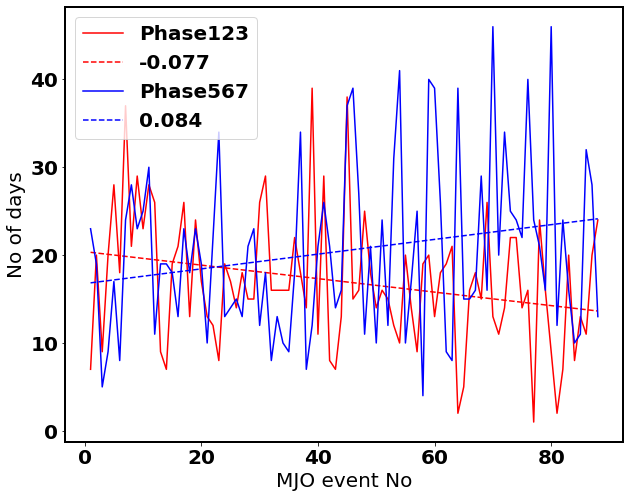

In [6]:
##### Student ttest ###########################
xx=np.arange(1,len(list)+1)
slope1,intercept1,corr1,p1,h1=linear_regress_scipy(xx,no_123,0.05,opt_detrend=0,opt_mktest=0)
slope2,intercept2,corr2,p2,h2=linear_regress_scipy(xx,no_567,0.05,opt_detrend=0,opt_mktest=0)

plt.plot(xx,no_123,'r')
plt.plot(xx,slope1*xx+intercept1,'r',linestyle='--')
plt.plot(xx,no_567,'b')
plt.plot(xx,slope2*xx+intercept2,'b',linestyle='--')
plt.legend(['Phase123',str(round(slope1,3)),'Phase567',str(round(slope2,3))])
plt.xlabel('MJO event No')
plt.ylabel('No of days')

# plt.savefig("trend_123_567_88.pdf",format='pdf', dpi=1000)
p1,h1,p2,h2

## Draw PDF for phase 1,2,3


/home/panini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/home/panini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  app.launch_new_instance()


array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
       26., 28., 30., 32., 34., 36., 38., 40., 42., 44., 46., 48., 50.])

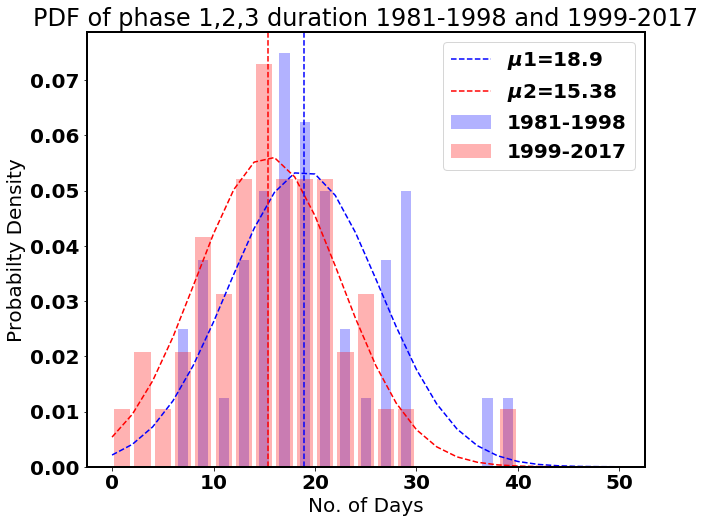

In [7]:
from scipy.stats import norm

no_123_ist=no_123[0:40]
no_123_2nd=no_123[40:]
bins = np.linspace(0, 50, 26)

mu1, std1 = norm.fit(no_123_ist)
mu2, std2 = norm.fit(no_123_2nd)
y1 = norm.pdf(bins, mu1, std1)
y2 = norm.pdf(bins, mu2, std2)



plt.hist(no_123_ist, bins, normed=1, facecolor='blue', alpha=0.3,rwidth=0.5)
plt.plot(bins, y1, 'b--')
plt.hist(no_123_2nd, bins, normed=1, facecolor='red', alpha=0.3,rwidth=0.8)
plt.plot(bins, y2, 'r--')


plt.xlabel('No. of Days')
plt.ylabel('Probabilty Density')
plt.legend(['$\mu$1='+str(round(mu1,2)),'$\mu$2='+str(round(mu2,2)),'1981-1998','1999-2017',])
plt.axvline(x=mu1,color='b',linestyle='--')
plt.axvline(x=mu2,color='r',linestyle='--')

plt.title("PDF of phase 1,2,3 duration 1981-1998 and 1999-2017")
# plt.savefig('PDF_88_123_adding.pdf',format='pdf', dpi=1000)
bins

## MW test for phase 123

In [8]:
# Mann-Whitney U test
from scipy.stats import mannwhitneyu
no_123_ist=no_123[0:41]
no_123_2nd=no_123[41:]
stat, p = mannwhitneyu(no_123_ist, no_123_2nd)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Samples are likely drawn from the same distributions (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=676.500, p=0.008
Different distribution (reject H0)


([<matplotlib.axis.XTick at 0x7f51af9a45f8>,
 <a list of 3 Text xticklabel objects>)

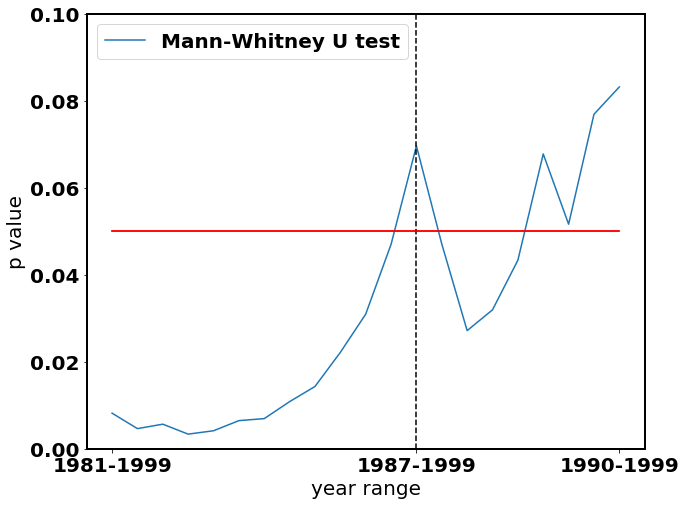

In [9]:
pvalues=[]
for i in np.arange(0,21):
    no_123_ist=no_123[i:41]
    no_123_2nd=no_123[41:]
    stat, p = mannwhitneyu(no_123_ist, no_123_2nd)
    pvalues.append(p)

plt.plot(pvalues)
# draw line at 95%, below which we reject H0
plt.plot([0.05 for x in range(len(pvalues))], color='red')
plt.legend(["Mann-Whitney U test"])
plt.ylabel("p value")
plt.xlabel("year range")
plt.ylim([0,.1])
plt.axvline(x=12,color='black',linestyle='--')
# draw line at 95%, below which we reject H0
plt.plot([0.05 for x in range(len(pvalues))], color='red')
plt.xticks([0,12,20], ('1981-1999', '1987-1999', '1990-1999'))
# plt.savefig("mann-whitney_phase123.pdf")

## Draw PDF of 5,6,7

/home/panini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  del sys.path[0]
/home/panini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'PDF of phase 5,6,7 duration 1981-1998 and 1999-2017')

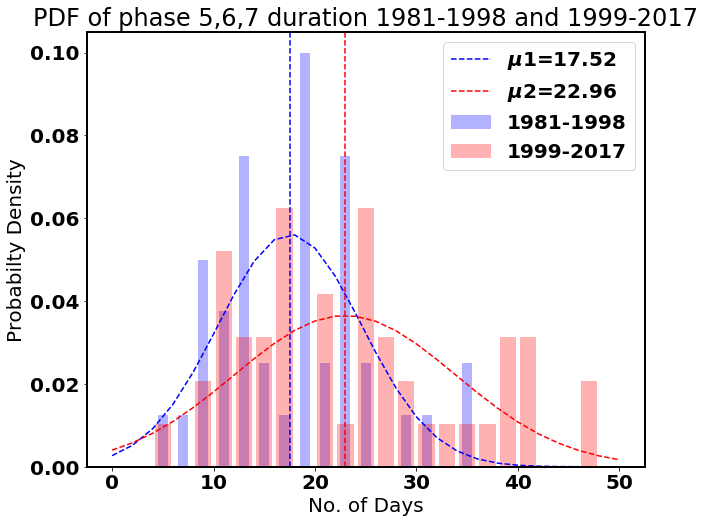

In [10]:
no_567_ist=no_567[0:40]
no_567_2nd=no_567[40:]
bins = np.linspace(0, 50, 26)



mu1, std1 = norm.fit(no_567_ist)
mu2, std2 = norm.fit(no_567_2nd)
y1 = norm.pdf(bins, mu1, std1)
y2 = norm.pdf(bins, mu2, std2)


plt.hist(no_567_ist, bins, normed=1, facecolor='blue', alpha=0.3,rwidth=0.5)
plt.plot(bins, y1, 'b--')
plt.hist(no_567_2nd, bins, normed=1, facecolor='red', alpha=0.3,rwidth=0.8)
plt.plot(bins, y2, 'r--')


plt.xlabel('No. of Days')
plt.ylabel('Probabilty Density')
plt.legend(['$\mu$1='+str(round(mu1,2)),'$\mu$2='+str(round(mu2,2)),'1981-1998','1999-2017',])
plt.axvline(x=mu1,color='b',linestyle='--')
plt.axvline(x=mu2,color='r',linestyle='--')
plt.title("PDF of phase 5,6,7 duration 1981-1998 and 1999-2017")
# plt.savefig('PDF_88_567_adding.pdf',format='pdf', dpi=1000)
# plt.savefig('fig2.png')

## MW  test

In [11]:
# Mann-Whitney U test
from scipy.stats import mannwhitneyu
no_567_ist=no_567[0:41]
no_567_2nd=no_567[41:]
stat, p = mannwhitneyu(no_567_ist, no_567_2nd)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=716.500, p=0.020
Different distribution (reject H0)


([<matplotlib.axis.XTick at 0x7f51ad805710>,
 <a list of 3 Text xticklabel objects>)

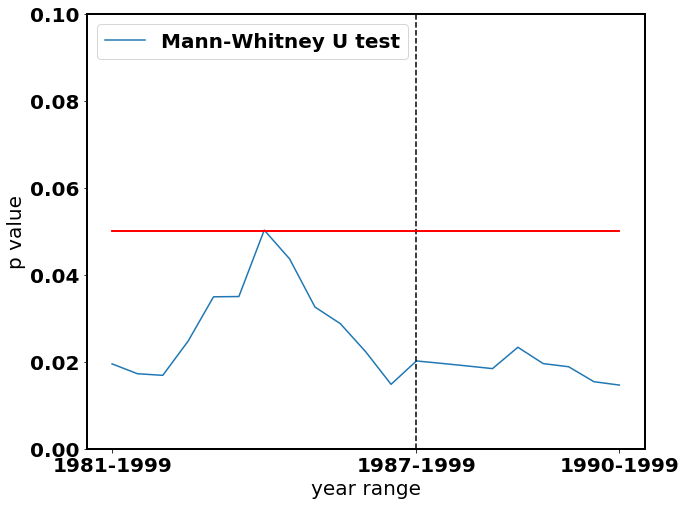

In [12]:
pvalues=[]
for i in np.arange(0,21):
    no_123_ist=no_567[i:41]
    no_123_2nd=no_567[41:]
    stat, p = mannwhitneyu(no_123_ist, no_123_2nd)
    pvalues.append(p)

plt.plot(pvalues)
# draw line at 95%, below which we reject H0
plt.plot([0.05 for x in range(len(pvalues))], color='red')
plt.plot([0.05 for x in range(len(pvalues))], color='red')
plt.legend(["Mann-Whitney U test"])
plt.ylabel("p value")
plt.xlabel("year range")
plt.ylim([0,.1])
plt.axvline(x=12,color='black',linestyle='--')
# draw line at 95%, below which we reject H0
plt.plot([0.05 for x in range(len(pvalues))], color='red')
plt.xticks([0,12,20], ('1981-1999', '1987-1999', '1990-1999'))
# plt.savefig("mann-whitney_phase567.pdf")

## Seasonal average phase duration in phase 1,2,3 and phase 5,6,7


In [13]:
x             =     loadmat('MJO_88.mat')  ### Reading the list of events from matfile 
mjo_rmm_prop  =     x["mjo_rmm_prop"]  

av_123        = np.zeros((mjo_rmm_prop.shape[1]))
av_567        = np.zeros((mjo_rmm_prop.shape[1]))
lf            = np.zeros((mjo_rmm_prop.shape[1]))

j=0
for i in np.arange(mjo_rmm_prop.shape[1]):
    mat=mjo_rmm_prop[0][i]
    ph=[]
    ap=[]
    
    for k in np.arange(mat.shape[0]):
        ph=ph+phase.sel(time=slice(list.iloc[j+k,1],list.iloc[j+k,2])).values.tolist()
        ap=ap+amp.sel(time=slice(list.iloc[j+k,1],list.iloc[j+k,2])).values.tolist()
        
    
    ph1=np.asarray(ph)
    ap1=np.asarray(ap)
    av_123[i]=np.size(np.where(ph1==1)[0])/mat.shape[0]+np.size(np.where(ph1==2)[0])/mat.shape[0]+np.size(np.where(ph1==3)[0])/mat.shape[0]
    av_567[i]=np.size(np.where(ph1==5)[0])/mat.shape[0]+np.size(np.where(ph1==6)[0])/mat.shape[0]+np.size(np.where(ph1==7)[0])/mat.shape[0]
    lf[i]    =len(ph1)/mat.shape[0]
    j=j+k+1
    


## Plotting the Seasonal average phase duration for 1,2,3 and 5,6,7 


(0.036275361228670984, 1.0, 0.06253844690423178, 1.0)

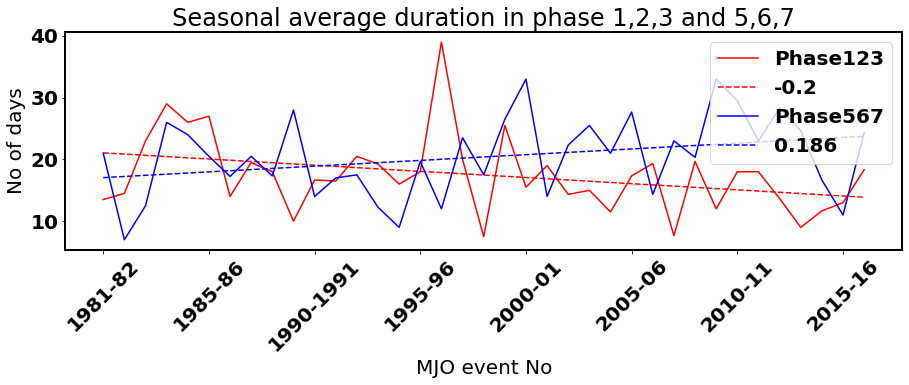

In [14]:
plt.figure(figsize=(15,4))
xx=np.arange(1,mjo_rmm_prop.shape[1]+1)
# slope1,intercept1,t_score1,t_critical1,p1,corr1,p_data1=linear_regress_trend(xx,av_123,0.975)
# slope2,intercept2,t_score2,t_critical2,p2,corr2,p_data2=linear_regress_trend(xx,av_567,0.975)

slope1,intercept1,corr1,p1,h1=linear_regress_scipy(xx,av_123,0.05,opt_detrend=0,opt_mktest=0)
slope2,intercept2,corr2,p2,h2=linear_regress_scipy(xx,av_567,0.07,opt_detrend=0,opt_mktest=0)

plt.plot(xx,av_123,'r')
plt.plot(xx,slope1*xx+intercept1,'r',linestyle='--')

plt.plot(xx,av_567,'b')
plt.plot(xx,slope2*xx+intercept2,'b',linestyle='--')

plt.legend(['Phase123',str(round(slope1,3)),'Phase567',str(round(slope2,3))])
plt.xlabel('MJO event No')
plt.ylabel('No of days')
plt.title('Seasonal average duration in phase 1,2,3 and 5,6,7')
plt.xticks(range(1, 37,5),['1981-82', '1985-86', '1990-1991','1995-96','2000-01','2005-06','2010-11','2015-16'],rotation=45)
# plt.savefig("trend_season_average_123_567_88_adding.pdf",format='pdf', dpi=1000)
p1,h1,p2,h2

## Calculating each season max min and plot error bar:

In [15]:
x             =     loadmat('MJO_88.mat')  ### Reading the list of events from matfile 
mjo_rmm_prop  =     x["mjo_rmm_prop"]  

sd_123        = np.zeros((mjo_rmm_prop.shape[1]))
sd_567        = np.zeros((mjo_rmm_prop.shape[1]))

j=0
for i in np.arange(mjo_rmm_prop.shape[1]):
    
    mat         =    mjo_rmm_prop[0][i]
    each_123    =    np.zeros((mat.shape[0]))
    each_567    =    np.zeros((mat.shape[0]))

    for k in np.arange(mat.shape[0]):
        ph=[]
        ap=[]
        ph=phase.sel(time=slice(list.iloc[j+k,1],list.iloc[j+k,2])).values
        ap=amp.sel(time=slice(list.iloc[j+k,1],list.iloc[j+k,2])).values
        each_123[k]=np.size(np.where(ph==1)[0])+np.size(np.where(ph==2)[0])+np.size(np.where(ph==3)[0])
        each_567[k]=np.size(np.where(ph==5)[0])+np.size(np.where(ph==6)[0])+np.size(np.where(ph==7)[0])

    
    
    sd_123[i]   =   np.std(each_123)
    sd_567[i]   =   np.std(each_567)

    j=j+k+1
    
    

## plotting the seasonal average with standard deviation errorbar :


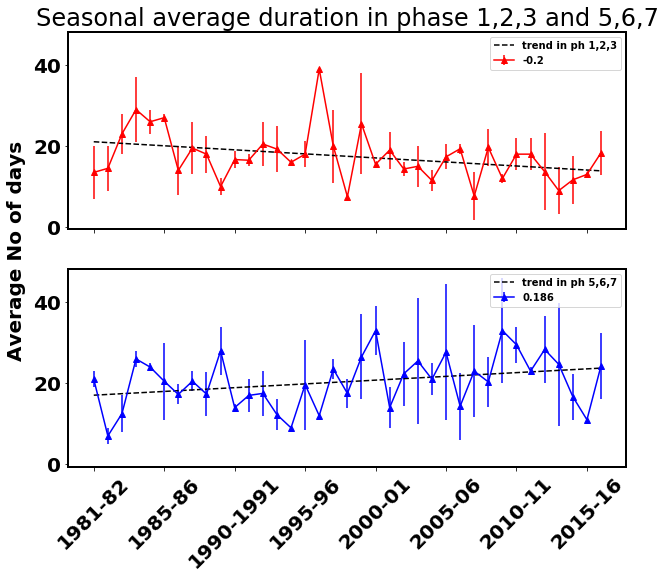

In [16]:
fig,ax    =  plt.subplots(2,1,sharex=True, sharey=True)
plt.setp(ax, xticks=range(1, 37,5), xticklabels=['1981-82', '1985-86', '1990-1991','1995-96','2000-01','2005-06','2010-11','2015-16'])
fig.text(0.04, 0.5, 'Average No of days', va='center', rotation='vertical')

ax[0].errorbar(xx,av_123,yerr=sd_123,linestyle='-', marker='^',color='r')
ax[0].plot(xx,slope1*xx+intercept1,'k',linestyle='--')
ax[0].tick_params(axis='x',rotation=45,labelsize=7)
ax[0].set_title('Seasonal average duration in phase 1,2,3 and 5,6,7')
ax[0].legend(['trend in ph 1,2,3',str(round(slope1,3))],fontsize=10)


ax[1].errorbar(xx,av_567,yerr=sd_567,linestyle='-', marker='^',color='b')
ax[1].plot(xx,slope2*xx+intercept2,'k',linestyle='--')
ax[1].tick_params(axis='x',rotation=45,labelsize=20)
ax[1].legend(['trend in ph 5,6,7',str(round(slope2,3))],fontsize=10)


# plt.savefig("trend_season_average_123_567_88_adding_with errorbar.pdf",format='pdf', dpi=1000)


## Seasonal average of indivual phase and phase 1,2,3 and phase 5,6,7


In [17]:
av_p       = np.zeros((mjo_rmm_prop.shape[1],8))


j=0
for i in np.arange(mjo_rmm_prop.shape[1]):
    mat=mjo_rmm_prop[0][i]
    ph=[]
    ap=[]
    
    for k in np.arange(mat.shape[0]):
        ph=ph+phase.sel(time=slice(list.iloc[j+k,1],list.iloc[j+k,2])).values.tolist()
        ap=ap+amp.sel(time=slice(list.iloc[j+k,1],list.iloc[j+k,2])).values.tolist()
        
    ph1=np.asarray(ph)
    ap1=np.asarray(ap)
    for j in np.arange(1,9,1):
        av_p[i,j-1]=np.size(np.where(ph1==j)[0])/mat.shape[0]

    j=j+k+1
    

In [18]:
AV_P=pd.DataFrame({'Ph1':av_p[:,0],'Ph2':av_p[:,1],'Ph3':av_p[:,2],'Ph4':av_p[:,3],'Ph5':av_p[:,4]\
                  ,'Ph6':av_p[:,5],'Ph7':av_p[:,6],'Ph8':av_p[:,7],'Ph123':av_123,'Ph567':av_567})
AV_P.to_csv('Average_phase_duration_88_events_adding.csv')


([<matplotlib.axis.XTick at 0x7f51af323a90>,
 <a list of 8 Text xticklabel objects>)

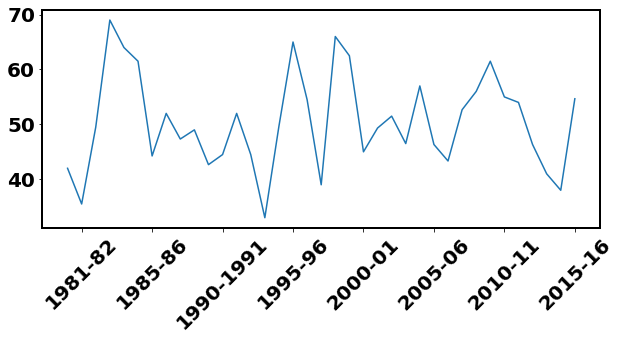

In [19]:
plt.figure(figsize=(10,4))
plt.plot(av_p[:,3]+av_123+av_567+av_p[:,7])
plt.xticks(range(1, 37,5),['1981-82', '1985-86', '1990-1991','1995-96','2000-01','2005-06','2010-11','2015-16'],rotation=45)
# plt.savefig('total_lifespan.pdf')